### For benchmarks with a smaller forest (`n_estimators=10`), see [here](https://gist.github.com/raghavrv/ccba90790bd4c6283e340de7f3f2d0bd)

#### Imports

In [1]:
import time

from collections import OrderedDict
from functools import partial

import numpy as np
import scipy as sp
from scipy.stats import rankdata

from sklearn.datasets import fetch_covtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# NOTE The add_indicator_feature is not in sklearn 0.18.0 This is a patched version for benchmarking...
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from scipy.io.arff import loadarff as scipy_loadarff
from arff import load as liac_loadarff

# https://github.com/pyarff/pyarff
# NOTE pyarff is very much experimental and is not finished fully yet
# scipy arff is a bit slow but doesn't encode categories.
# LIAC is another arff reader that works on sparse too but sometimes breaks with
# datasets that surround data with quotes
import pyarff

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt

import pygraphviz as pgv

from sklearn.tree import export_graphviz
from io import BytesIO

def get_graph(dtc, n_classes, feat_names=None, size=[7, 7]):
    # Get the dot graph of our decision tree
    tree_dot = export_graphviz(
        dtc, out_file=None, feature_names=feat_names, rounded=True, filled=True,
        special_characters=True, class_names=list(map(str, range(n_classes))), max_depth=10)
    # Convert this dot graph into an image
    g = pgv.AGraph(tree_dot)
    g.layout('dot')
    g.draw(path='temp.png')
    # Plot it
    plt.figure().set_size_inches(*size)
    plt.axis('off')
    plt.imshow(img.imread(fname='temp.png'))
    plt.show()

rng = np.random.RandomState(0)

all_datasets = OrderedDict()

#### Basic Demo of DecisionTreeClassifier handling missing values natively

In [2]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(missing_values='NaN')

# Class 0 if missing or <= 3.5
# Class 1 if not missing and > 3.5
dtc.fit([[np.nan,], [np.nan,], [np.nan,], [1,], [2,], [3,], [4,], [5,], [6,]],
        [0, 0, 0, 0, 0, 0, 1, 1, 1])
print(dtc.predict([[np.nan], [0,], [7,], [3.6,]]))

[0 0 1 1]


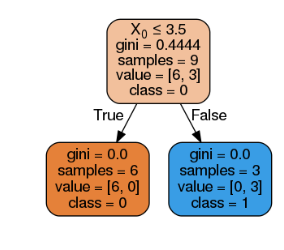

In [3]:
g = get_graph(dtc, n_classes=2, size=[3, 3])

### Let's do some benchmarks on real world datasets that have missing values

In [4]:
# Anneal dataset - http://www.openml.org/d/2

meta1, data1 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/anneal.arff')
data1 = data1[:-1]  # The last one seems to have a wrong class label. Check pyarff.
X, y = data1[:, :-1], data1[:, -1]
all_datasets['anneal'] = (X, y)

In [5]:
# KDDCUP09_churn - http://www.openml.org/d/1112

# start = time.time()
# data = scpy_arff_load('/home/raghavrv/code/datasets/arff/KDDCup09_churn.arff')[0]
# print("KDDCUP09_churn ARFF dataset loaded in %0.8fs" % (time.time() - start))
# X = np.array([np.array(list(data_i))[:190] for data_i in data]).astype(float)
# y = np.array([data_i[-1] for data_i in data]).astype(int)

meta2, data2 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/KDDCup09_churn.arff',
                                        encode_nominals=True)
X, y = data2[:, :-1], data2[:, -1]
all_datasets['KDDCUP09_churn'] = (X, y)

In [6]:
# KDDCUP09_appetency - http://www.openml.org/d/1111

meta3, data3 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/KDDCup09_appetency.arff',
                                        encode_nominals=True)
X, y = data3[:, :-1], data3[:, -1]
all_datasets['KDDCUP09_appetency'] = (X, y)

In [7]:
# KDDCUP09_upselling - http://www.openml.org/d/1114

meta4, data4 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/KDDCup09_upselling.arff',
                                        encode_nominals=True)
X, y = data4[:, :-1], data4[:, -1]
all_datasets['KDDCUP09_upselling'] = (X, y)

In [8]:
# CSJ - http://www.openml.org/d/23380

meta5, data5 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/cjs.arff',
                                        encode_nominals=True)

target_index = meta5['attributes'][b'TR']['order']
X = np.hstack((data5[:, :target_index], data5[:, target_index+1:])).astype(float)
y = data5[:, target_index].astype(int)
all_datasets['cjs'] = (X, y)

In [9]:
# Soy Bean dataset - http://www.openml.org/d/42

meta6, data6 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/soybean.arff',
                                        encode_nominals=True)
X, y = data6[:, :-1].astype(float), data6[:, -1].astype(int)
y[-1] = 2  # The last label seems to not be loaded properly (Pyarff bug)
all_datasets['soy_bean'] = (X, y)

In [10]:
# Adult Census dataset - https://archive.ics.uci.edu/ml/datasets/Adult

meta, data = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/adult-census.arff',
                                      encode_nominals=True)
X, y = data[:, :-1].astype(float), data[:, -1].astype(int)
all_datasets['adult_census'] = (X, y)

np.bincount(y)

array([    0, 24720,  7841])

In [11]:
# Lymphoma 2 classes - http://www.openml.org/d/1101

meta7, data7 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/lymphoma_2classes.arff',
                                        encode_nominals=True)
X, y = data7[:, :-1].astype(float), data7[:, -1].astype(int)
all_datasets['lymphoma_2classes'] = (X, y)

np.bincount(y)

array([ 0, 22, 23])

In [12]:
# Lymphoma 9 classes - http://www.openml.org/d/1102


meta8, data8 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/lymphoma_9classes.arff',
                                        encode_nominals=True)
X, y = data8[:, :-1].astype(float), data8[:, -1].astype(int)
all_datasets['lymphoma_9classes'] = (X, y)

np.bincount(y)

array([ 0, 46,  2,  2, 10,  6,  6,  9,  4, 11])

In [13]:
# KDD98 - http://www.openml.org/d/23513

meta9, data9 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/kdd98_data.arff',
                                        encode_nominals=True)
target_index = meta9['attribute_names_in_order'].index(b'TARGET_B')
X = np.hstack([data9[:, :target_index], data9[:, target_index+1:]]).astype(float)
y = data9[:, target_index].astype(int)
all_datasets['kdd98'] = (X, y)

In [14]:
# Colleges US News binarized - http://www.openml.org/d/930

# data10_ = scipy_loadarff('/home/raghavrv/code/datasets/arff/colleges_usnews.arff')[0]
# X_ = np.array([list(data_i) for data_i in data10_])[:-1]
# y_ = np.array([data_i[-1] for data_i in data10_])[:-1]

meta10, data10 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/colleges_usnews.arff',
                                          encode_nominals=True)
data10 = data10[:-1]  # The last one seems to have a wrong class label. Bug in pyarff.
X, y = data10[:, :-1].astype(float), data10[:, -1].astype(int)
all_datasets['colleges_usnews'] = (X, y)

In [15]:
# arrhythmia - http://www.openml.org/d/5

meta11, data11 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/dataset_5_arrhythmia.arff',
                                          encode_nominals=True)

target_index = meta11['attributes'][b'class']['order']
X = np.hstack((data11[:, :target_index], data11[:, target_index+1:])).astype(float)
y = data11[:, target_index].astype(int)
all_datasets['arrhythmia'] = (X, y)

In [16]:
# Vote - http://www.openml.org/d/56

meta12, data12 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/vote.arff',
                                          encode_nominals=True)
target_index = meta12['attributes'][b'Class']['order']
X = np.hstack((data12[:, :target_index], data12[:, target_index+1:])).astype(float)
y = data12[:, target_index].astype(int)
all_datasets['vote'] = (X, y)

np.bincount(y)

array([  0, 267, 168])

In [17]:
# Pro Football Scores - http://www.openml.org/d/470

meta13, data13 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/profb.arff',
                                          encode_nominals=True)
target_index = meta13['attributes'][b'Home/Away']['order']
X = np.hstack((data13[:, :target_index], data13[:, target_index+1:])).astype(float)
y = data13[:, target_index].astype(int)
all_datasets['pro football scores'] = (X, y)

In [18]:
# Mice Protein - http://www.openml.org/d/4550

meta14, data14 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/mice.arff',
                                          encode_nominals=True)
target_index = meta14['attributes'][b'class']['order']
X = np.hstack((data14[:, :target_index], data14[:, target_index+1:])).astype(float)
y = data14[:, target_index].astype(int)
all_datasets['mice_protein'] = (X, y)

In [19]:
# IPUMS98 small - http://www.openml.org/d/381

meta14, data14 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/ipums_la_98-small.arff',
                                          encode_nominals=True)
target_index = meta14['attributes'][b'movedin']['order']
X = np.hstack((data14[:, :target_index], data14[:, target_index+1:])).astype(float)
y = data14[:, target_index].astype(int)
all_datasets['ipums_98'] = (X, y)

In [20]:
# IPUMS97 small - http://www.openml.org/d/381

meta, data = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/ipums_la_97-small.arff',
                                      encode_nominals=True)
target_index = meta['attributes'][b'movedin']['order']
X = np.hstack((data[:, :target_index], data[:, target_index+1:])).astype(float)
y = data[:, target_index].astype(int)
all_datasets['ipums_97'] = (X, y)

class_count = np.bincount(y)
classes = np.unique(y)
print(list(zip(classes, class_count[classes.tolist()])))

[(1, 1938), (2, 869), (3, 528), (4, 889), (5, 1227), (6, 1000), (7, 310), (8, 258)]


In [21]:
# IPUMS99 small - http://www.openml.org/d/381

meta16, data16 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/ipums_la_99-small.arff',
                                          encode_nominals=True)
target_index16 = meta16['attributes'][b'movedin']['order']
X16 = np.hstack((data16[:, :target_index16], data16[:, target_index16+1:])).astype(float)
y16 = data16[:, target_index16].astype(int)
all_datasets['ipums_99'] = (X16, y16)

class_count16 = np.bincount(y16)
classes16 = np.unique(y16)
print(list(zip(classes16, class_count16[classes16.tolist()])))

[(1, 5803), (2, 710), (3, 901), (4, 403), (5, 560), (6, 270), (7, 197)]


In [22]:
# Census Income Dataset (Large) - http://sci2s.ugr.es/keel/dataset.php?cod=195

meta17, data17 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/more_missing_datasets/census.arff',
                                          encode_nominals=True)
target_index17 = meta17['attributes'][b'Class']['order']
X17 = np.hstack((data17[:, :target_index17], data17[:, target_index17+1:])).astype(float)
y17 = data17[:, target_index17].astype(int)
all_datasets['census_income_large'] = (X17, y17)

class_count17 = np.bincount(y17)
classes17 = np.unique(y17)
print(list(zip(classes17, class_count17[classes17.tolist()])))

[(1, 280716), (2, 18568)]


In [23]:
import warnings
warnings.filterwarnings("ignore")

n_jobs = 16
n_estimators = 100

cv=StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

all_benchmarks = OrderedDict()
all_score_ranks = OrderedDict()
all_time_ranks = OrderedDict()

for dataset_desc, (X, y) in all_datasets.items():
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_classes = np.unique(y).shape[0]
    benchmarks = []  # Tuple of (<technique>, mean cross val score, total fit time)

    missing_mask = np.isnan(X)
    missing_samples, missing_features = np.where(missing_mask)
    print("Dataset %s with %d samples and %d features. n_classes=%d; It has %0.4f%% values missing" 
          % (dataset_desc, n_samples, n_features, n_classes,
             100. * (np.sum(missing_mask) / (n_samples * n_features))))
    print("====================================================================================================\n")

    # 1) Estimate score with RFC natively handling missing values
    estimator = RandomForestClassifier(random_state=0, n_jobs=n_jobs,
                                       missing_values="NaN", n_estimators=n_estimators)
    scores = cross_val_score(estimator, X, y, cv=cv)
    score, score_err = scores.mean(), sp.stats.sem(scores)
    
    start = time.time()
    estimator.fit(X, y)
    benchmarks.append(('Random Forest natively handling it', scores, time.time() - start))
    
    
    
    
    
    # 2) Estimate score after mean imputation of missing values without indicator features
    estimator = Pipeline([("Impute", Imputer(missing_values="NaN", strategy="mean",
                                             add_indicator_features=False, axis=0)),
                          ("rf", RandomForestClassifier(random_state=0,
                                                       n_jobs=n_jobs, n_estimators=n_estimators))])
    scores = cross_val_score(estimator, X, y, cv=cv)
    score, score_err = scores.mean(), sp.stats.sem(scores)
    
    start = time.time()
    estimator.fit(X, y)
    benchmarks.append(('mean imputation of the missing values', scores, time.time() - start))
    
    
    
    
    
    # 3) Estimate score after mean imputation of the missing values with indicator matrix
    estimator = Pipeline([("Impute", Imputer(missing_values="NaN", strategy="mean",
                                             add_indicator_features=True, axis=0)),
                          ("rf", RandomForestClassifier(random_state=0,
                                                       n_jobs=n_jobs, n_estimators=n_estimators))])
    scores = cross_val_score(estimator, X, y, cv=cv)
    score, score_err = scores.mean(), sp.stats.sem(scores)
    
    start = time.time()
    estimator.fit(X, y)
    benchmarks.append(('mean imputation of the missing values w/indicator features', scores, time.time() - start))
    
    
    
    
    
    
    # 4) Estimate score after median imputation of missing values without indicator features
    estimator = Pipeline([("Impute", Imputer(missing_values="NaN", strategy="median",
                                             add_indicator_features=False, axis=0)),
                          ("rf", RandomForestClassifier(random_state=0,
                                                       n_jobs=n_jobs, n_estimators=n_estimators))])
    scores = cross_val_score(estimator, X, y, cv=cv)
    score, score_err = scores.mean(), sp.stats.sem(scores)
    
    start = time.time()
    estimator.fit(X, y)
    benchmarks.append(('median imputation of the missing values', scores, time.time() - start))
    
    
    
    
    
    
    
    # 5) Estimate score after median imputation of the missing values with indicator matrix
    estimator = Pipeline([("Impute", Imputer(missing_values="NaN", strategy="median",
                                             add_indicator_features=True, axis=0)),
                          ("rf", RandomForestClassifier(random_state=0,
                                                       n_jobs=n_jobs, n_estimators=n_estimators))])
    scores = cross_val_score(estimator, X, y, cv=cv)
    score, score_err = scores.mean(), sp.stats.sem(scores)
    
    start = time.time()
    estimator.fit(X, y)
    benchmarks.append(('median imputation of the missing values w/indicator features', scores, time.time() - start))

    
    
    
    
    all_benchmarks[dataset_desc] = benchmarks

    names, scores, times = list(zip(*benchmarks))
    
    scores = np.array(scores)
    ## Per estimator/technique, compute the ranks based on the score per fold 
    #ranks = np.array(list(rankdata(scores[:, i], method='min') for i in range(scores.shape[1]))).T
    #ranks_score = rankdata(ranks.mean(axis=1), method='min')

    scores = scores.mean(axis=1)
    ranks_score = rankdata(-scores, method='min')
    #print(ranks_score)
    ranks_fit_time = rankdata(times, method='min')
        
    all_score_ranks[dataset_desc] = ranks_score
    all_time_ranks[dataset_desc] = ranks_fit_time

    for i, benchmark in enumerate(benchmarks):
        print("%s Got a score of %0.8f [%s] with %s (Train time %0.2fs [%s] %s)"
              % ("*" if ranks_score[i] == 1 else " ",
                 benchmark[1].mean(), ranks_score[i], benchmark[0],
                 benchmark[2], ranks_fit_time[i],
                 "*" if ranks_fit_time[i] == 1 else " "))
        
    start = time.time()
    estimator.fit(X, y)
    print()

Dataset anneal with 897 samples and 38 features. n_classes=2; It has 64.9856% values missing

* Got a score of 0.99500000 [1] with Random Forest natively handling it (Train time 0.18s [1] *)
  Got a score of 0.99444444 [3] with mean imputation of the missing values (Train time 0.19s [2]  )
  Got a score of 0.99472222 [2] with mean imputation of the missing values w/indicator features (Train time 0.19s [3]  )
  Got a score of 0.95861111 [5] with median imputation of the missing values (Train time 0.19s [5]  )
  Got a score of 0.99277778 [4] with median imputation of the missing values w/indicator features (Train time 0.19s [4]  )

Dataset KDDCUP09_churn with 50000 samples and 230 features. n_classes=2; It has 69.7752% values missing

* Got a score of 0.92661500 [1] with Random Forest natively handling it (Train time 5.39s [2]  )
  Got a score of 0.92660500 [2] with mean imputation of the missing values (Train time 5.47s [3]  )
  Got a score of 0.92660500 [2] with mean imputation of the 

### Benchmark Summary

Benchmark summary

19 datasets were tested.

n_estimators=100 and 
cv=StratifiedShuffleSplit(n_splits=20, random_state=0, test_size=0.2,
            train_size=None)



----------------------------------------------------------------------------------------------------
Random Forest natively handling it 

--> got ranked by score 
 - 1st (9 / 19 times) 2nd (5 / 19 times) 3rd (3 / 19 times) 4th (1 / 19 times) 5th (1 / 19 times) 

--> got ranked by lower fit-time on entire dataset 
 - 1st (7 / 19 times) 2nd (3 / 19 times) 3rd (3 / 19 times) 4th (2 / 19 times) 5th (4 / 19 times) 

----------------------------------------------------------------------------------------------------


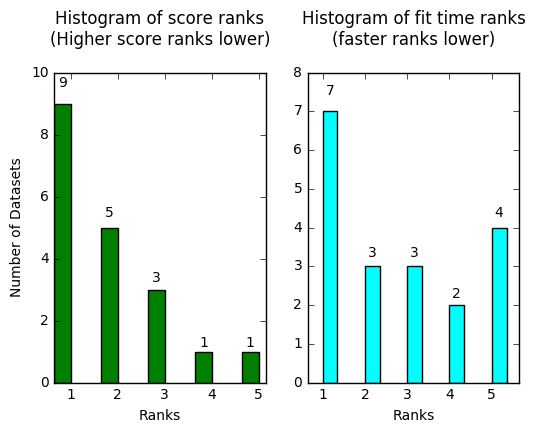


mean imputation of the missing values 

--> got ranked by score 
 - 1st (5 / 19 times) 2nd (7 / 19 times) 3rd (4 / 19 times) 4th (1 / 19 times) 5th (2 / 19 times) 

--> got ranked by lower fit-time on entire dataset 
 - 1st (5 / 19 times) 2nd (5 / 19 times) 3rd (3 / 19 times) 4th (2 / 19 times) 5th (4 / 19 times) 

----------------------------------------------------------------------------------------------------


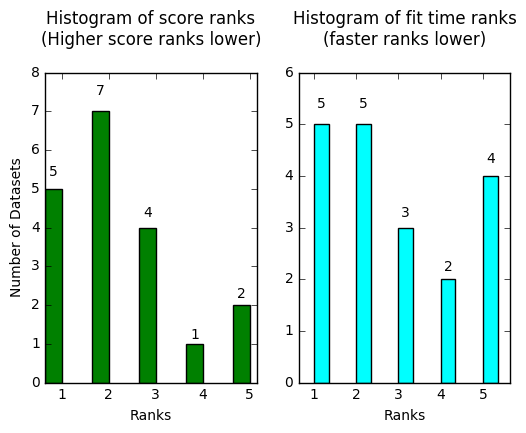


mean imputation of the missing values w/indicator features 

--> got ranked by score 
 - 1st (3 / 19 times) 2nd (3 / 19 times) 3rd (1 / 19 times) 4th (9 / 19 times) 5th (3 / 19 times) 

--> got ranked by lower fit-time on entire dataset 
 - 1st (5 / 19 times) 2nd (4 / 19 times) 3rd (8 / 19 times) 4th (1 / 19 times) 5th (1 / 19 times) 

----------------------------------------------------------------------------------------------------


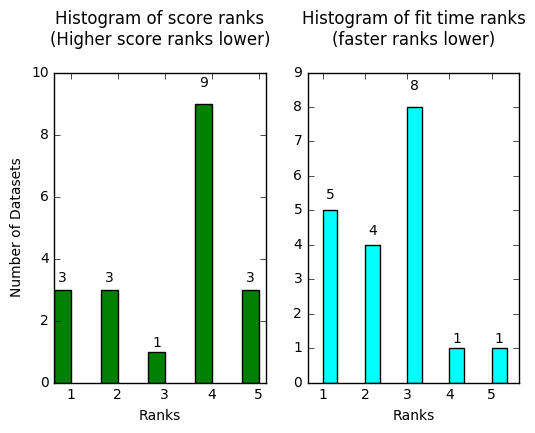


median imputation of the missing values 

--> got ranked by score 
 - 1st (7 / 19 times) 2nd (2 / 19 times) 3rd (3 / 19 times) 4th (2 / 19 times) 5th (5 / 19 times) 

--> got ranked by lower fit-time on entire dataset 
 - 1st (2 / 19 times) 2nd (5 / 19 times) 3rd (2 / 19 times) 4th (6 / 19 times) 5th (4 / 19 times) 

----------------------------------------------------------------------------------------------------


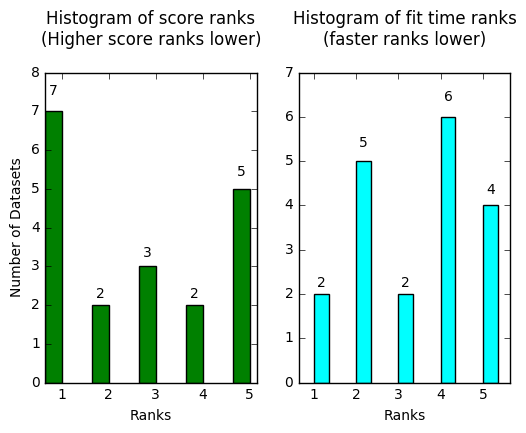


median imputation of the missing values w/indicator features 

--> got ranked by score 
 - 1st (4 / 19 times) 2nd (2 / 19 times) 3rd (3 / 19 times) 4th (6 / 19 times) 5th (4 / 19 times) 

--> got ranked by lower fit-time on entire dataset 
 - 1st (0 / 19 times) 2nd (2 / 19 times) 3rd (3 / 19 times) 4th (8 / 19 times) 5th (6 / 19 times) 

----------------------------------------------------------------------------------------------------


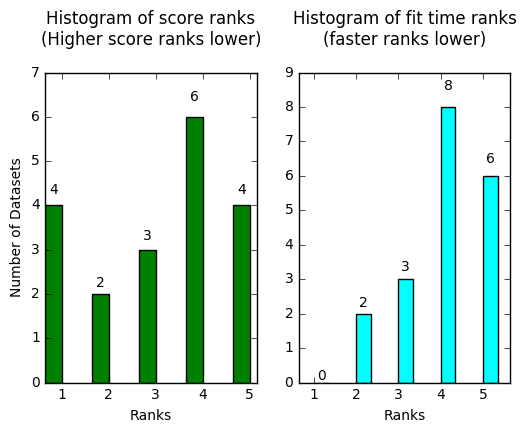

In [24]:
print("Benchmark summary")
print("=================")


methods = list(zip(*next(iter(all_benchmarks.values()))))[0]
n_methods = len(methods)

n_datsets = len(all_benchmarks)
rank_suffix = [None, 'st', 'nd', 'rd', 'th', 'th']


print("\n%d datasets were tested.\n\nn_estimators=%d and \ncv=%s" 
      % (n_datsets, n_estimators, str(cv)))
print("\n\n")


score_ranks_per_method = list(zip(*list(all_score_ranks.values())))
_bincount_ = partial(np.bincount, minlength=n_methods + 1)
bincount_score_ranks_per_method = list(map(_bincount_, score_ranks_per_method))
fittime_ranks_per_method = list(zip(*list(all_time_ranks.values())))
bincount_fittime_ranks_per_method = list(map(_bincount_, fittime_ranks_per_method))


print('-' * 100)

for i, method in enumerate(methods):
    print(method, '\n')

    score_rank_counts = bincount_score_ranks_per_method[i][1:]
    time_rank_counts = bincount_fittime_ranks_per_method[i][1:]

    rank_stats = "".join(("%d%s (%d / %d times) "
                          %  (r, rank_suffix[r], score_rank_counts[r-1], n_datsets))
                          for r in range(1, 6))
    print("--> got ranked by score \n - %s" % (rank_stats))
    print()
    rank_stats = "".join(("%d%s (%d / %d times) "
                          %  (r, rank_suffix[r], time_rank_counts[r-1], n_datsets))
                          for r in range(1, 6))
    print("--> got ranked by lower fit-time on entire dataset \n - %s" % (rank_stats))
    print()
    
    print('-' * 100)
    
    # Plot histogram of ranks


    ind = np.array([1, 2, 3, 4, 5])  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots(1, 2)
    ax[0].set_ylim((0, max(score_rank_counts) + 1))
    ax[1].set_ylim((0, max(time_rank_counts) + 1))


    rects1 = ax[0].bar(ind, score_rank_counts, width, color='g')
    rects2 = ax[1].bar(ind + width, time_rank_counts, width, color='cyan')

    # add some text for labels, title and axes ticks
    ax[0].set_ylabel('Number of Datasets')
    ax[0].set_xlabel('Ranks')
    
    ax[0].set_title('Histogram of score ranks\n(Higher score ranks lower)\n')
    ax[0].set_xticks(ind + width)
    ax[0].set_xticklabels(('1', '2', '3', '4', '5'))
    
    ax[1].set_xlabel('Ranks')
    ax[1].set_title('Histogram of fit time ranks\n(faster ranks lower)\n')
    ax[1].set_xticks(ind + width)
    ax[1].set_xticklabels(('1', '2', '3', '4', '5'))
    
    def autolabel(rects, ax):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1, ax[0])
    autolabel(rects2, ax[1])
    
    plt.show()
    print('=' * 100)
    print() 